# Import Library

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

# Data Scraping

In [2]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_close_datas = {}
stock_open_datas = {}
stock_high_datas = {}
stock_low_datas = {}
stock_volume_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-28', interval='1d')
  stock_open_datas[ticker] = df['Open']
  stock_high_datas[ticker] = df['High']
  stock_low_datas[ticker] = df['Low']
  stock_volume_datas[ticker] = df['Volume']
  stock_close_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_close_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926025,716.897949,1457.917480,2289.992676,2592.610596,1390.0,3430.840576,5383.927734,3732.603516,7525.143066
2018-01-02,3723.926025,723.661133,1439.693481,2283.701416,2543.998779,1410.0,3407.658691,5319.062500,3685.474609,7694.248047
2018-01-03,3723.926025,723.661133,1403.245483,2271.119385,2495.387451,1390.0,3268.570801,5221.762207,3553.514160,7694.248047
2018-01-04,3779.189697,716.897949,1348.573853,2233.371826,2535.896973,1390.0,3260.843750,5335.278320,3544.088623,7715.386230
2018-01-05,3783.440674,720.279541,1385.021729,2258.536621,2535.896973,1390.0,3307.206543,5383.927734,3506.385498,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-21,9700.000000,19950.000000,9500.000000,4260.000000,5450.000000,50825.0,2750.000000,4670.000000,4520.000000,10825.000000
2025-05-22,9650.000000,19950.000000,9525.000000,4300.000000,5450.000000,51800.0,2800.000000,4630.000000,4470.000000,10800.000000
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


# Data Preprocessing

## Menangani Missing Value

In [4]:
df_all.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    1
ASII.JK    1
BBNI.JK    0
ICBP.JK    1
dtype: int64

In [5]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.053223,1153.150635,1209.519775,2880.276123,2881.316895,1450.0,NaN,NaN,3534.166504,NaN


Melakukan Forward fill untuk mengisi data yang hilang pada `TLKM.JK`, `ASII.JK`, dan `ICBP.JK`

In [6]:
df_all_ffil = df_all.ffill()
display(df_all_ffil.loc["2019-06-18"])
display(df_all_ffil.loc["2019-06-19"])

BBCA.JK    5117.359375
BYAN.JK    1160.313110
TPIA.JK    1202.114380
BBRI.JK    2860.134521
BMRI.JK    2836.155029
DSSA.JK    1450.000000
TLKM.JK    3145.500732
ASII.JK    5101.783691
BBNI.JK    3464.674561
ICBP.JK    9077.742188
Name: 2019-06-18 00:00:00, dtype: float64

BBCA.JK    5152.053223
BYAN.JK    1153.150635
TPIA.JK    1209.519775
BBRI.JK    2880.276123
BMRI.JK    2881.316895
DSSA.JK    1450.000000
TLKM.JK    3145.500732
ASII.JK    5101.783691
BBNI.JK    3534.166504
ICBP.JK    9077.742188
Name: 2019-06-19 00:00:00, dtype: float64

In [7]:
df_all_ffil.shape

(1820, 10)

In [8]:
df_all_ffil.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    0
ASII.JK    0
BBNI.JK    0
ICBP.JK    0
dtype: int64

## Menangani Tanggal yang Terlewat dengan Forward Fill

Dilakukan Pengecekan terhadap berapa banyak hari yang tidak terdapat dalam data

In [9]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 884


Melakukan Forward Fill untuk mengisi tanggal yang hilang dengan cara menyebarkan data nilai terakhir yang diketahui ke depan hingga nilai berikutnya yang tidak hilang

In [10]:
df_all_ffil = df_all_ffil.reindex(full_date_range).ffill()
df_all_ffil.index.name = 'Date'
df_all_ffil

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926025,716.897949,1457.917480,2289.992676,2592.610596,1390.0,3430.840576,5383.927734,3732.603516,7525.143066
2018-01-02,3723.926025,723.661133,1439.693481,2283.701416,2543.998779,1410.0,3407.658691,5319.062500,3685.474609,7694.248047
2018-01-03,3723.926025,723.661133,1403.245483,2271.119385,2495.387451,1390.0,3268.570801,5221.762207,3553.514160,7694.248047
2018-01-04,3779.189697,716.897949,1348.573853,2233.371826,2535.896973,1390.0,3260.843750,5335.278320,3544.088623,7715.386230
2018-01-05,3783.440674,720.279541,1385.021729,2258.536621,2535.896973,1390.0,3307.206543,5383.927734,3506.385498,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


Melakukan pengecekan apakah tanggal yang hilang sudah berhasil diisi semuanya

In [11]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 0


## Mengganti Nama Kolom

In [12]:
df_all_ffil.columns = df_all_ffil.columns.str.replace('.JK', '', regex=False)
df_all_ffil

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926025,716.897949,1457.917480,2289.992676,2592.610596,1390.0,3430.840576,5383.927734,3732.603516,7525.143066
2018-01-02,3723.926025,723.661133,1439.693481,2283.701416,2543.998779,1410.0,3407.658691,5319.062500,3685.474609,7694.248047
2018-01-03,3723.926025,723.661133,1403.245483,2271.119385,2495.387451,1390.0,3268.570801,5221.762207,3553.514160,7694.248047
2018-01-04,3779.189697,716.897949,1348.573853,2233.371826,2535.896973,1390.0,3260.843750,5335.278320,3544.088623,7715.386230
2018-01-05,3783.440674,720.279541,1385.021729,2258.536621,2535.896973,1390.0,3307.206543,5383.927734,3506.385498,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [13]:
df_all_ffil = df_all_ffil.reset_index()
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,716.897949,1457.917480,2289.992676,2592.610596,1390.0,3430.840576,5383.927734,3732.603516,7525.143066
1,2018-01-02,3723.926025,723.661133,1439.693481,2283.701416,2543.998779,1410.0,3407.658691,5319.062500,3685.474609,7694.248047
2,2018-01-03,3723.926025,723.661133,1403.245483,2271.119385,2495.387451,1390.0,3268.570801,5221.762207,3553.514160,7694.248047
3,2018-01-04,3779.189697,716.897949,1348.573853,2233.371826,2535.896973,1390.0,3260.843750,5335.278320,3544.088623,7715.386230
4,2018-01-05,3783.440674,720.279541,1385.021729,2258.536621,2535.896973,1390.0,3307.206543,5383.927734,3506.385498,7842.215332
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


## Menangani Duplikasi Data

In [14]:
print("Jumlah duplikasi data:", df_all_ffil.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [15]:
df_all_ffil = df_all_ffil.sort_values(by="Date", ascending=True)
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,716.897949,1457.917480,2289.992676,2592.610596,1390.0,3430.840576,5383.927734,3732.603516,7525.143066
1,2018-01-02,3723.926025,723.661133,1439.693481,2283.701416,2543.998779,1410.0,3407.658691,5319.062500,3685.474609,7694.248047
2,2018-01-03,3723.926025,723.661133,1403.245483,2271.119385,2495.387451,1390.0,3268.570801,5221.762207,3553.514160,7694.248047
3,2018-01-04,3779.189697,716.897949,1348.573853,2233.371826,2535.896973,1390.0,3260.843750,5335.278320,3544.088623,7715.386230
4,2018-01-05,3783.440674,720.279541,1385.021729,2258.536621,2535.896973,1390.0,3307.206543,5383.927734,3506.385498,7842.215332
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [16]:
df_all_ffil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2704 non-null   datetime64[ns]
 1   BBCA    2704 non-null   float64       
 2   BYAN    2704 non-null   float64       
 3   TPIA    2704 non-null   float64       
 4   BBRI    2704 non-null   float64       
 5   BMRI    2704 non-null   float64       
 6   DSSA    2704 non-null   float64       
 7   TLKM    2704 non-null   float64       
 8   ASII    2704 non-null   float64       
 9   BBNI    2704 non-null   float64       
 10  ICBP    2704 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 232.5 KB


Terdapat nilai null pada beberapa kolom

In [17]:
df_all_ffil.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,2704,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000
mean,2021-09-13 12:00:00,6647.044800,7508.757346,3075.294022,3323.686691,3496.613427,7859.921413,3136.352787,4521.508767,3383.968304,9258.538777
min,2018-01-01 00:00:00,3529.552979,591.778992,1093.920776,1513.757080,1411.886963,920.000000,2070.656494,2251.151611,1292.781372,6683.180664
25%,2019-11-07 18:00:00,5111.655762,1164.566772,1722.659424,2546.368835,2476.076172,1497.500000,2783.105957,4184.783325,2789.609131,8028.596191
50%,2021-09-13 12:00:00,6205.837158,1432.485474,2247.613892,3233.821167,2806.314453,2212.500000,3051.436646,4564.072266,3421.679932,9129.916016
75%,2023-07-21 06:00:00,8451.989258,17800.614258,2599.425293,3979.260986,4483.701050,5000.000000,3534.067383,4890.240845,3988.644043,10396.153320
max,2025-05-27 00:00:00,10570.414062,22548.173828,10625.000000,5763.100098,6769.004883,53900.000000,4295.701172,5738.722656,5460.848145,12800.000000
std,NaN,1897.875968,8006.582778,2358.763379,936.935368,1349.876983,12444.669658,468.294402,633.273780,899.857008,1393.909449


## Analisis Harga Saham Tiap Perusahaan

In [18]:
dates = df_all_ffil['Date']
stocks = df_all_ffil.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

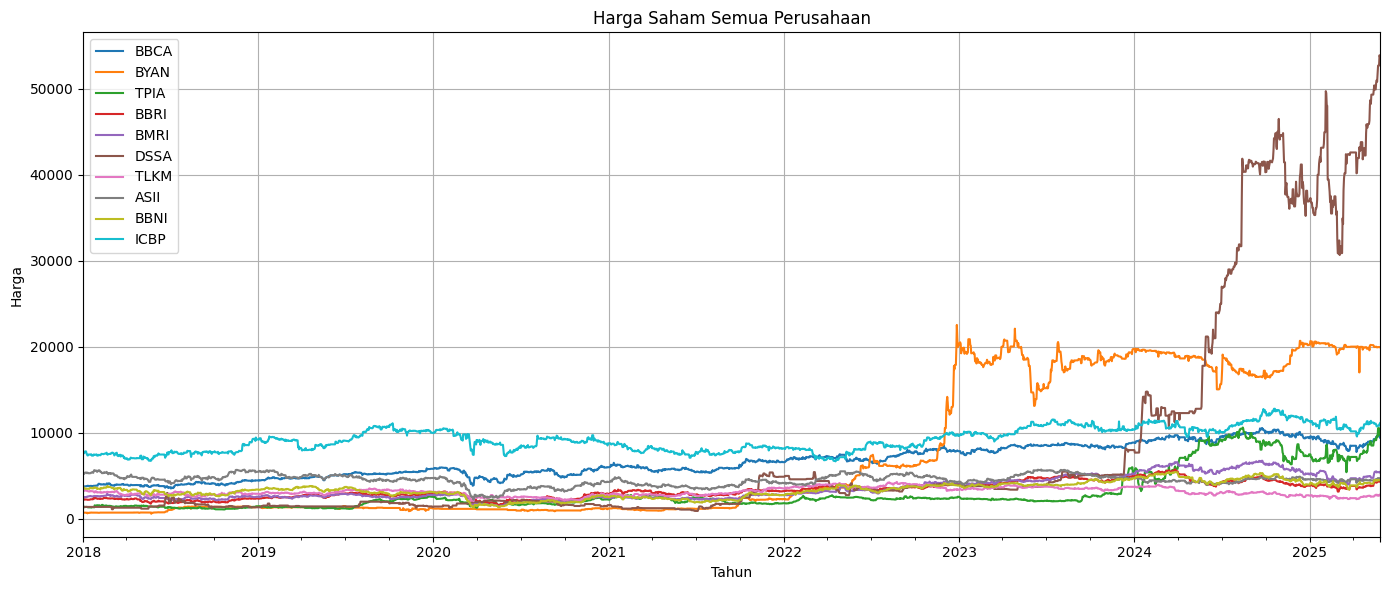

In [19]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

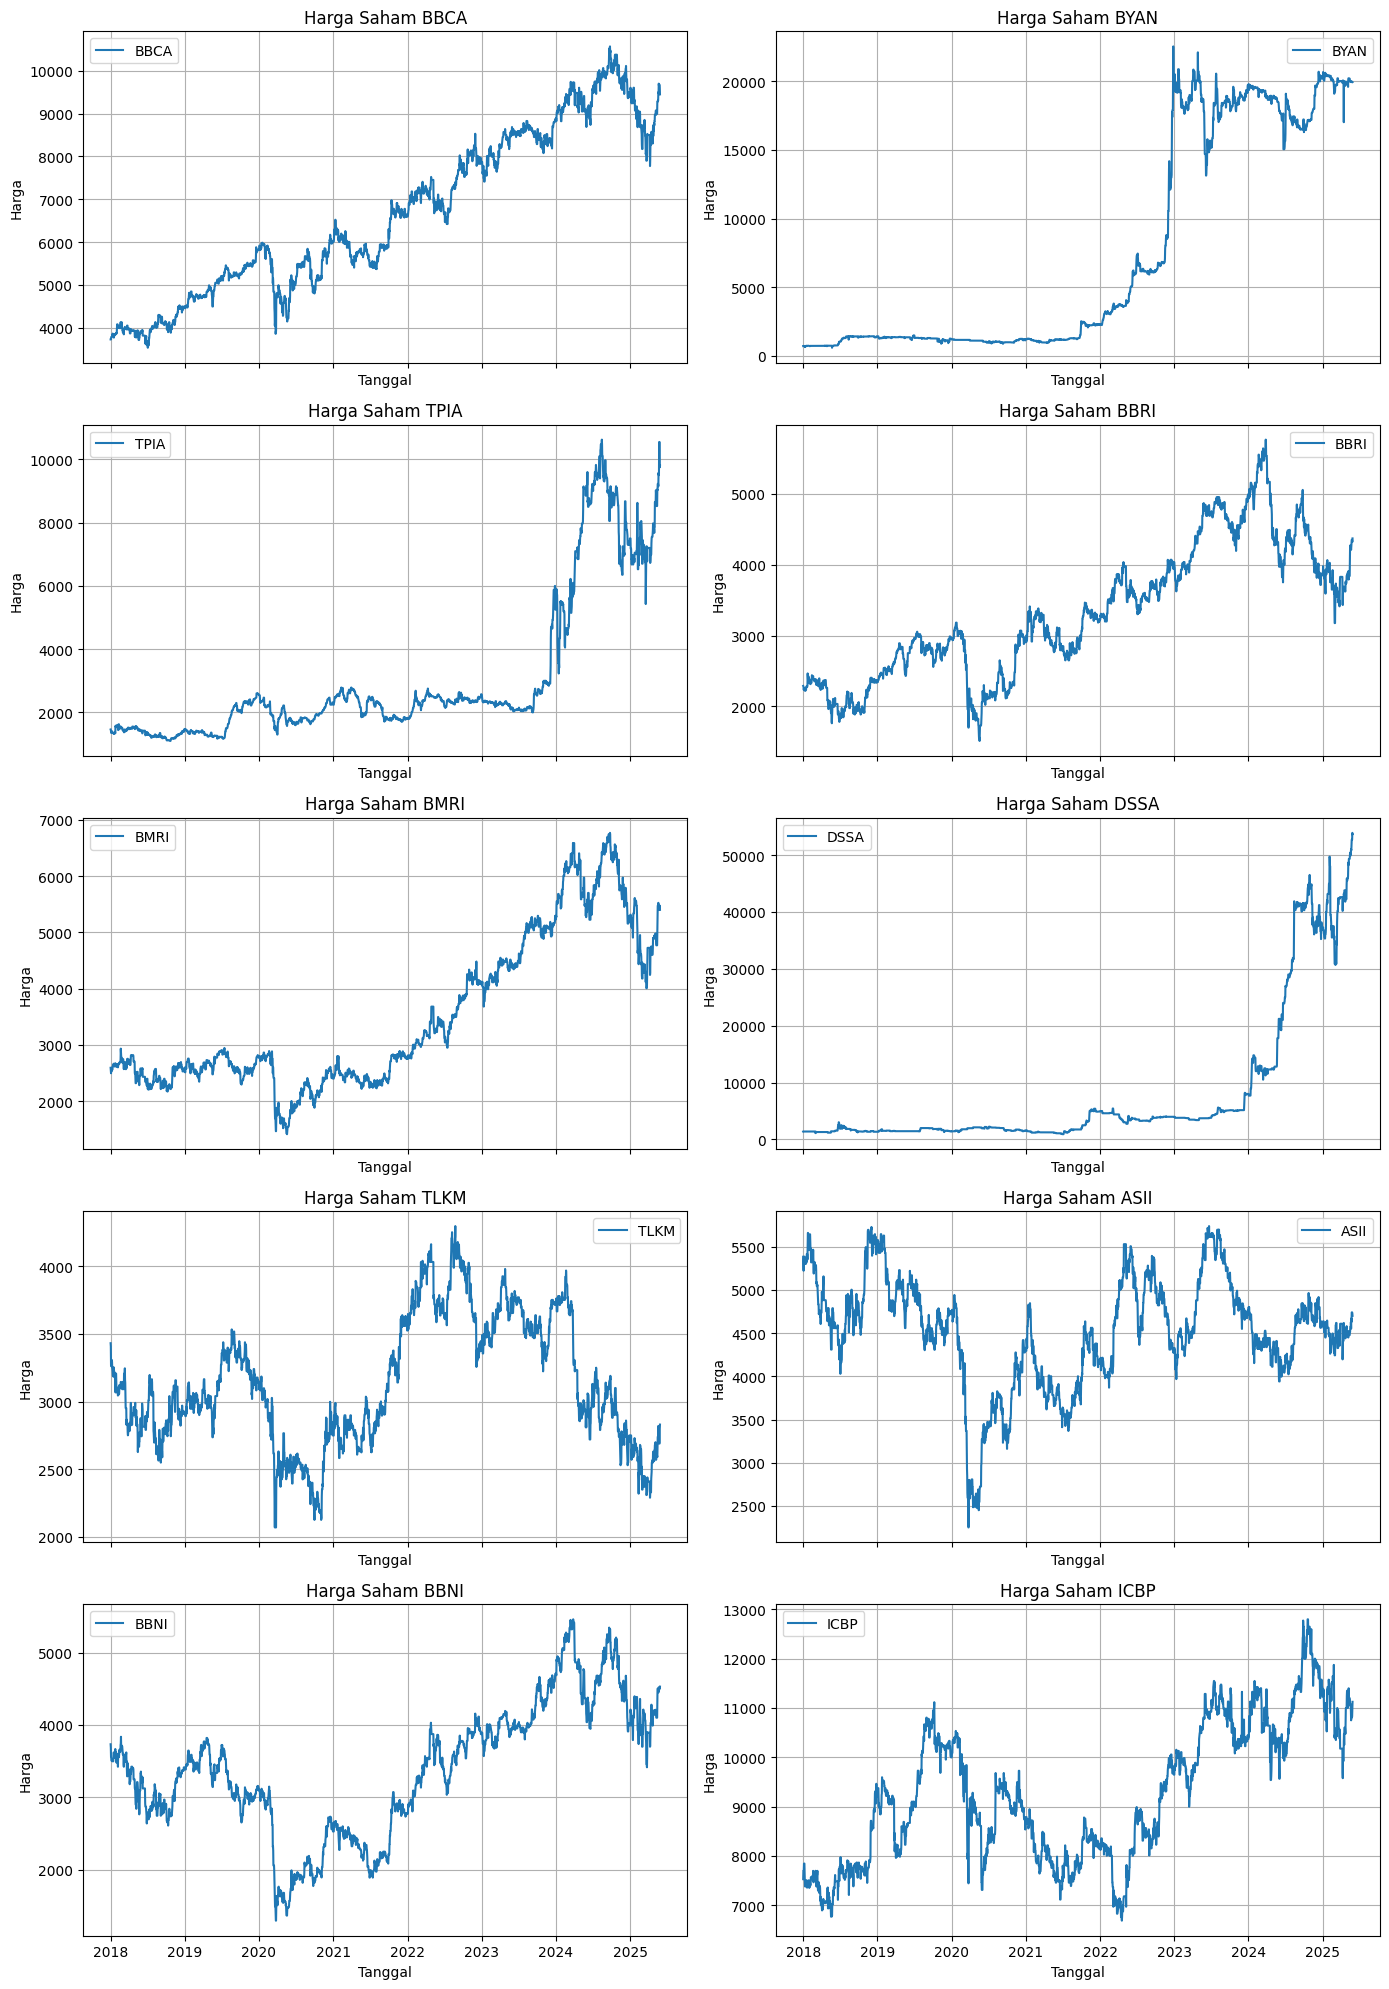

In [20]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

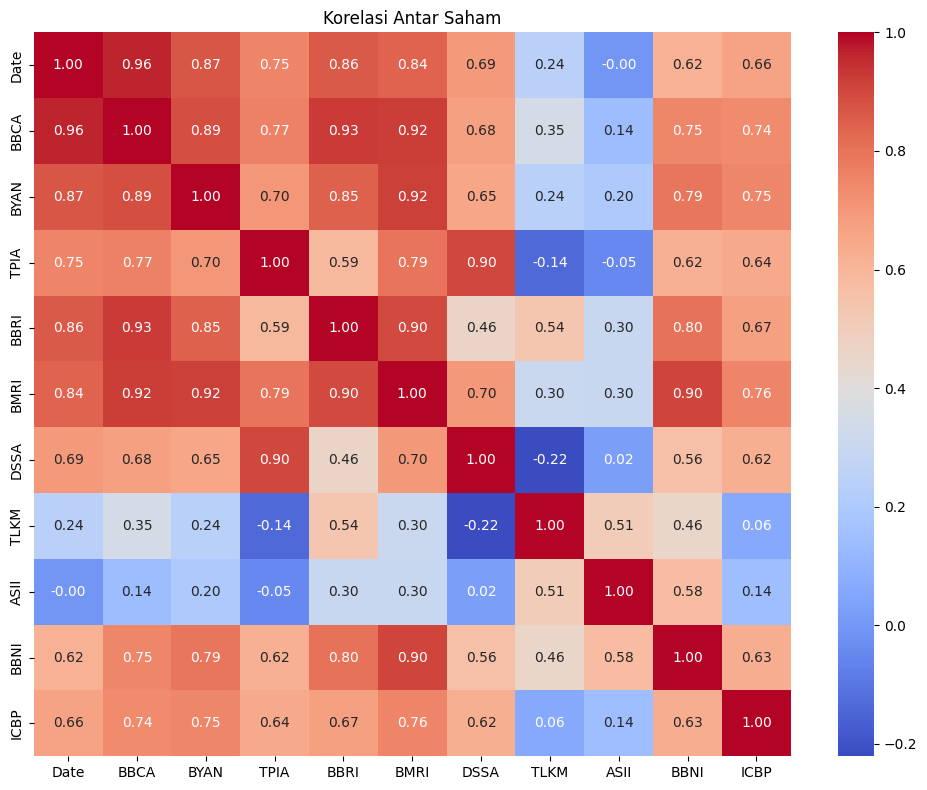

In [21]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all_ffil.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [22]:
# Saving data to csv
df_all_ffil.to_csv("stocks.csv", index=False)

## Standarisasi Data

In [23]:
scalers = {}
standardized_stocks = {}

for symbol, series in df_all_ffil.items():
    scaler = StandardScaler()
    series = series.values.reshape(-1, 1)  # Ensure 2D for scaler
    standardized = scaler.fit_transform(series)
    scalers[symbol] = scaler
    standardized_stocks[symbol] = standardized.squeeze()  # Back to 1D

## Data Splitting & Windowing

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer = 1000

def split_dataset(series):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X).reshape(-1, window_size, 1), np.array(y)

X_all, y_all = [], []
for series in standardized_stocks.values():
    X, y = split_dataset(series)
    X_all.append(X)
    y_all.append(y)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

# Shuffle
indices = np.arange(len(X_all))
np.random.shuffle(indices)
X_all, y_all = X_all[indices], y_all[indices]

# Split
total_len = len(X_all)
train_size = int(0.7 * total_len)
eval_size = int(0.15 * total_len)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_eval = X_all[train_size:train_size + eval_size]
y_eval = y_all[train_size:train_size + eval_size]
X_test = X_all[train_size + eval_size:]
y_test = y_all[train_size + eval_size:]

## Windowing

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
combined_ds = None
for symbol, series in standardized_stocks.items():
    ds = windowed_dataset(series, window_size=30, batch_size=32, shuffle_buffer=1000)
    combined_ds = ds if combined_ds is None else combined_ds.concatenate(ds)

# Modeling

In [55]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam', metrics=['mape'])

model.summary()
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [56]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_eval, y_eval),
    epochs=10
)

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.1222 - mape: 40.2675 - val_loss: 0.0571 - val_mape: 26.3664
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0495 - mape: 19.6015 - val_loss: 0.0429 - val_mape: 15.2311
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0362 - mape: 18.3009 - val_loss: 0.0361 - val_mape: 12.9404
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0338 - mape: 15.9068 - val_loss: 0.0350 - val_mape: 13.3171
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0340 - mape: 18.7589 - val_loss: 0.0328 - val_mape: 13.0566
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0328 - mape: 16.3433 - val_loss: 0.0344 - val_mape: 14.7400
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0334 - mape: 19.0467 - val_loss: 0.0331 - val_mape: 12.4151
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0330 - mape: 12.3638 - val_loss: 0.0343 - val_mape: 12.8479
Epoch 9/

In [57]:
# Evaluasi di test data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
MAE: 0.0301
RMSE: 0.0639
MAPE: 0.2183


# Inference

In [28]:
def predict_future(series, steps_ahead, window_size, scaler):
    last_window = series[-window_size:].reshape(-1, 1)
    input_seq = scaler.transform(last_window).reshape(1, window_size, 1).astype(np.float32)

    preds = []
    for _ in range(steps_ahead):
        pred = model.predict(input_seq, verbose=0)[0, 0]
        preds.append(pred)
        input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1).astype(np.float32)
    return preds

forecast_steps = {
    '1_day': 1,
    '1_week': 7,
    '1_month': 30,
    '3_months': 90,
    '6_months': 180
}

symbols = ['BBCA', 'BYAN', 'TPIA', 'BBRI', 'BMRI', 'DSSA', 'TLKM', 'ASII', 'BBNI', 'ICBP']
for symbol in symbols:
    original_series = df_all_ffil[symbol].values
    scaler = scalers[symbol]

    result = {}
    preds_std = {}  # (opsional: untuk menyimpan prediksi terstandarisasi)

    for label, steps in forecast_steps.items():
        preds_std[label] = predict_future(original_series, steps, window_size, scaler)
        preds_original = scaler.inverse_transform(np.array(preds_std[label]).reshape(-1, 1)).flatten()
        result[label] = float(preds_original[-1])

    print(f"Forecast for {symbol}: {result}")

Forecast for BBCA: {'1_day': 9431.283203125, '1_week': 9343.8291015625, '1_month': 9034.3740234375, '3_months': 8473.65625, '6_months': 7976.8525390625}
Forecast for BYAN: {'1_day': 19877.994140625, '1_week': 19454.193359375, '1_month': 18024.224609375, '3_months': 15479.25390625, '6_months': 13270.677734375}
Forecast for TPIA: {'1_day': 9775.4501953125, '1_week': 9473.3681640625, '1_month': 8307.544921875, '3_months': 6511.34521484375, '6_months': 5319.27978515625}
Forecast for BBRI: {'1_day': 4366.36279296875, '1_week': 4342.93017578125, '1_month': 4252.4404296875, '3_months': 4066.174560546875, '6_months': 3883.931640625}
Forecast for BMRI: {'1_day': 5388.9150390625, '1_week': 5333.03564453125, '1_month': 5131.6875, '3_months': 4757.52734375, '6_months': 4420.11865234375}
Forecast for DSSA: {'1_day': 52950.921875, '1_week': 50160.87890625, '1_month': 41530.7734375, '3_months': 28659.791015625, '6_months': 20821.4140625}
Forecast for TLKM: {'1_day': 2831.8779296875, '1_week': 2843.28

# Save Model

In [29]:
model.save("model/model_lstm.h5")